# Improving Deep-Autoregressive Models with Spectral Attention
## Synthetic Dataset Experiment

This notebook evaluates the Frequency Attentive Autoregressive Model with a LSTM embedding using a synthetic dataset. Similar results can be obtained executing the script "evaluate_FAAM_general.py" inside the folder "Synthetic_Datasets_Exps" of the repository. For the evaluation of the model we use the pre-trained one available in "experiments/synthetic/best.pth.tar".

We also utilise this notebook to briefly illustrate how the Frequency Attentive Autoregressive Model works.

First, we load the required packages.

In [1]:
import argparse
import SAAM_general.net as net
from dataloaders.dataloader_sin_cos import Data_Seq_sin_cos
import matplotlib
import matplotlib.pyplot as plt
import utils_SAAM_general as utils
import random
import os
import logging
import torch
import numpy as np
from tqdm import tqdm
import sys
from evaluate.evaluate_SAAM_general import evaluate
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")
print(torch.__version__) 
#Changes on the fft functions used in this code were implemented in last Pytorch update. Updating the used methods is pending, for the moment, make sure to use <= pytorch 1.7

1.7.1


We need to set some requiered parameters. In the ".py" scripts, these are inputed through the parser.

In [2]:
model_dir = os.path.join('experiments/synthetic')
json_path = os.path.join(model_dir, 'params.json')
params = utils.Params(json_path)
utils.set_logger(os.path.join(model_dir, 'eval.log'))
params.relative_metrics = True
params.model_dir = model_dir
params.plot_dir = os.path.join(model_dir, 'figures')
params.compute_rp = True
params.sampling = False
try:
    os.mkdir(params.plot_dir)
except FileExistsError:
    pass

We now load the model and print a summary of it. For this especific case, the embedding was performed by a LSTM with 3 layers and 10 hidden units per layer. Considering that we are using a LSTM for the embedding, the FAAM trained here is equivalent to DeepAR plus the Frequency Attentive Module proposed in the paper.

In [3]:
params.device = torch.device('cpu')
print('Not using cuda...')
model = net.Net(params)
print('FAAM: ', model)

Not using cuda...
FAAM:  Net(
  (lstm): LSTM(1, 10, num_layers=3, dropout=0.1)
  (attn): SA_module(
    (attn_l): Linear(in_features=60, out_features=30, bias=True)
    (sig): Sigmoid()
    (attn_g_dim_change): Linear(in_features=101, out_features=30, bias=True)
    (attn_g): Linear(in_features=60, out_features=30, bias=True)
  )
  (relu): ReLU()
  (distribution_mu): Linear(in_features=30, out_features=1, bias=True)
  (distribution_presigma): Linear(in_features=30, out_features=1, bias=True)
  (distribution_sigma): Softplus(beta=1, threshold=20)
)


Now, it is time to load the dataset. Here, we are working with the synthetic data explained in the paper. The time series of this datasets have a duration of 200 samples. Each of these signals is divided in two halfs, randomly selecting the components for each of them as:

\begin{equation}
\label{eq:synthethic}
f(t)=\left\{\begin{array}{ll}
        \left\{\begin{array}{ll}
            f_1(t), \text{ if } x=0\\
            f_2(t), \text{ if } x=1
        \end{array}\right., & t \in[0, 100) \\
        \\
        \left\{\begin{array}{ll}
            f_1(t), \text{ if } x=0\\
            f_2(t), \text{ if } x=1
        \end{array}\right., & t \in[100, 200],
\end{array}\right.
\end{equation}

Where $x$ is randomly generated from a Bernoulli distribution, $X \sim Ber(\theta)$, with probability mass function: $\operatorname{Ber}(x \mid \theta)=\theta^{\mathbb{I}(x=1)}(1-\theta)^{\mathbb{I}(x=0)}$ and $\theta = 1/2$. This means that each half can take the form of one over two signals, $f_1(t)$ or $f_2(t)$, both of them composed by the addition of two sines of different frequencies and a noise component:

\begin{equation}
    \label{eq:synthethic}
    \left\{\begin{array}{ll}
    f_1(t)=A_{1} \sin (2 \pi f_1 t) + A_{2} \sin (2 \pi f_2 t) + N, \\
    f_2(t)=A_{3} \sin (2 \pi f_3 t) + A_{4} \sin (2 \pi f_4 t) + N,
    \end{array}\right.
\end{equation}

In this example, we fix $A_1, A_2, A_3, A_4 = 2$ and the frequencies components to $f_1=1, f_2=20, f_3=5, f_4=20$ to facilitate the visualization. The noise component follows a gaussian distributions $N \sim \mathcal{N}(0, \sigma)$, where $\sigma=0.5$ for the experiment of this notebook.	

In the next figure, we plot some time-series from this dataset as examples. In each of them, the variance of the noise component is different in order to show how this affects the time series.

![title](experiments/synthetic/timeseries_ex.pdf)

We proceed to load the data:

In [4]:
print('Loading the datasets...')
data = Data_Seq_sin_cos()
batch_size_train = params.batch_size
batch_size_test = params.predict_batch
train_loader, test_loader,test_set, complete_dataset_test = data.getData(batch_size_train=batch_size_train,batch_size_test=batch_size_test, sigma_noise=0.5)
params.lstm_input_size = train_loader.sampler.data_source.tensors[0].shape[-1]
print('Loading complete.')

Loading the datasets...
Loading complete.


We can reload now the weights from a pre-trained model. To train a new one, consult the script "train_FAAM_general.py". We also set a loss function.

In [5]:
utils.load_checkpoint(os.path.join(model_dir, 'best.pth.tar'), model)
loss_fn = net.loss_fn

Now we perform a validation of the loaded model in the synthetic dataset with a noise variance of $\sigma_N=0.5$. We iterate through differents $t_0$ and $\tau$, which define the forecast horizon and its length.

The metrics used to report the model's results are the Normalized Deviation (ND) and Root Mean Square Error (RMSE):

\begin{equation} 
	\begin{split}
	\mathrm{ND} &=\frac{\sum_{i, t}\left|z_{i, t}-\hat{z}_{i, t}\right|}{\sum_{i, t}\left|z_{i, t}\right|} \\[5pt]
	\text { RMSE } &=\frac{\sqrt{\frac{1}{N\left(T-t_{0}\right)} \sum_{i, t}\left(z_{i, t}-\hat{z}_{i, t}\right)^{2}}}{\frac{1}{N\left(T-t_{0}\right)} \sum_{i, t}\left|z_{i, t}\right|}\\[5pt]
	\end{split}
\end{equation}

Also, the $\rho-$quantile loss, $QL_{\rho}$, with $\rho \in (0, 1)$ is used:

\begin{equation}
	\begin{split}
	\mathrm{QL}_{\rho}(z, \hat{z})&=2 \frac{\sum_{i, t} P_{\rho}\left(z_{t}^{(i)}, \hat{z}_{t}^{(i)}\right)}{\sum_{i, t}\left|z_{t}^{(i)}\right|},\\
	\quad P_{\rho}(z, \hat{z})&=\left\{\begin{array}{ll}
	\rho(z-\hat{z}) & \text { if } z>\hat{z}, \\
	(1-\rho)(\hat{z}-z) & \text { otherwise }
	\end{array}\right.
	\end{split}
\end{equation}

We proceed to set the values to test for the forecast horizon and to evaluate the model:

In [6]:
t0 = [175, 150, 120, 110, 105]
tau = [25, 50, 80, 90, 95]
N = len(t0)

In [7]:
for n in range(N):

    print ("**************")
    print ("Steps: "+str(tau[n]))
    print ("**************")

    params.predict_start = t0[n]
    params.test_predict_start = t0[n]
    params.predict_steps = tau[n]

    test_metrics = evaluate(model, loss_fn, test_loader, params, tau[n], params.sampling, force_plot_spectral=True)


  0%|          | 0/2 [00:00<?, ?it/s]

**************
Steps: 25
**************


  0%|          | 0/2 [00:00<?, ?it/s]

**************
Steps: 50
**************


  0%|          | 0/2 [00:00<?, ?it/s]

**************
Steps: 80
**************


  0%|          | 0/2 [00:00<?, ?it/s]

**************
Steps: 90
**************


  0%|          | 0/2 [00:00<?, ?it/s]

**************
Steps: 95
**************


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


We plot now an example of the predictions done by the model, specifically for the case of $\{t_0 = 120, \tau = 80\}$. The green line defines the forecast horizon while blue vertical lines indicates randomly time instants selected to plot some model's internal variables below.

NOTE: First rows in the next figures are the sequences with worst results. Last ones report best metrics.

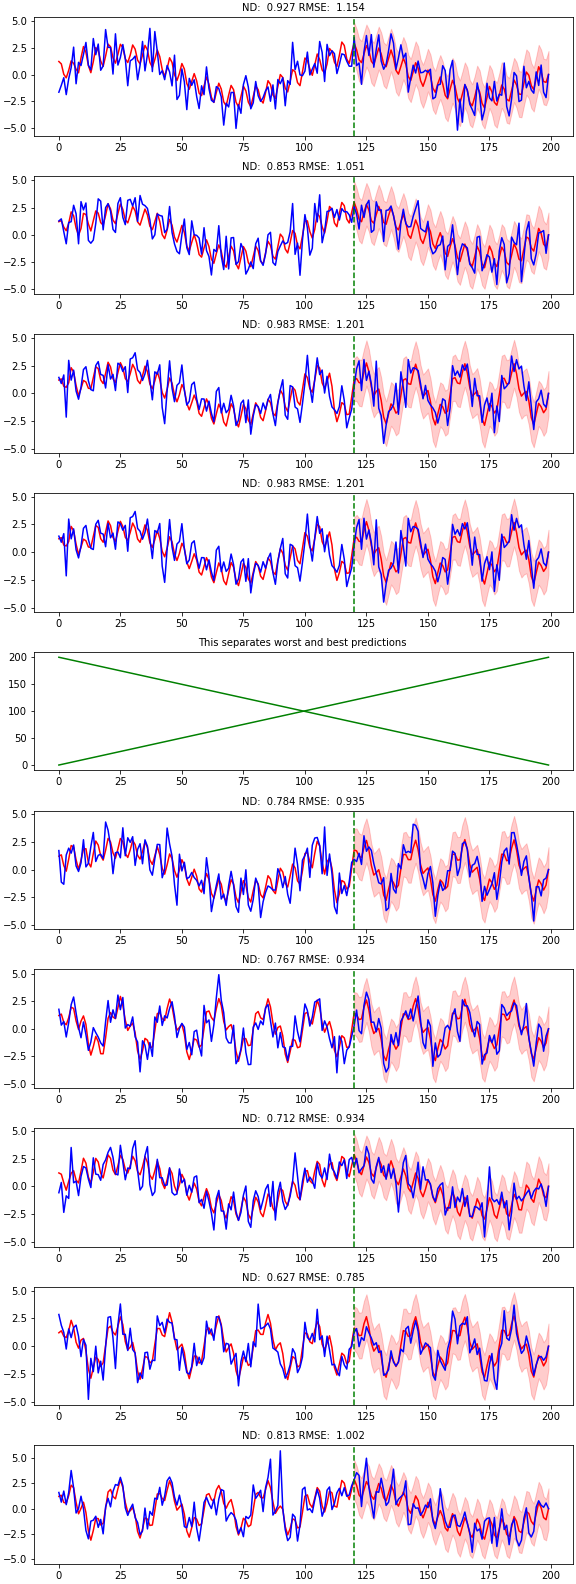

In [8]:
selected_tau = 80
PATH = 'experiments/synthetic/figures/'+str(selected_tau)+'.png'
Image(filename = PATH, width=400, height=1000)